# Executing a Parflow Subsetting Workflow

In [1]:
from hera.workflows import Steps, Step, Workflow, script, WorkflowsService
from hera.workflows.models import WorkflowTemplateRef, TemplateRef
from hera.shared import global_config

In [2]:
# token is obtained from https://workflows.argo.cuahsi.io/userinfo
argo_token = "v2:eyJhbGciOiJSU0EtT0FFUC0yNTYiLCJlbmMiOiJBMjU2R0NNIiwiemlwIjoiREVGIn0.Jmwv5MWyI9zAt3zM5teLzoXAu3VbTicO9I-HtPdI88nRp_ETGXkFQqC5aM_msNYlJSF5ncrugC5RexrhvxPIq5tZeWHDG9dzif6TDn1Z6G8vuicIcbwKCbhtveFWoJHUNO4rz714Rt5decdPeIwxBTJ2bKoPnK8HZtrit2fDseJOrD9EYBUSpjMZt-aiSGD7SuHye08kNggmHVEzfNOx-ehXI2doq62_bqZNNOOLR4H_p48SV2DVaQHU28yH5dVKBPoS9gQcxM0UTeadyjNm4M_I4s4-g-8tVDhzadUih6rtFw33smvK_gjon30N4mtUP2rNrhLjGy701bbj_RnFRA.7RZ66x0RfHrFzmBA.0ntF913jQdh3Urda5EOMqMI2Gzn59ttOcmfmX3dfvkLzSjktGK6UTcQE7d3lLRPejzeOrfe0LfFVjVcJDFvkQoITZIHhBtc.Q81RRcNnwtUKQ0y5hknjiw"
argo_host  = "https://workflows.argo.cuahsi.io"
argo_ns    = "workflows"

In [3]:
ws=WorkflowsService(host=argo_host,
                   token=argo_token,
                   namespace=argo_ns)

Test the connection

In [4]:
ws.get_info()

InfoResponse(links=None, managed_namespace=None, modals=None, nav_color=None)

Define a function to print job status

In [5]:
import time
import datetime 

def display_status(workflow):
    job_name = workflow.name

    # initial values
    finished_at = None
    start_time = None
    
    print(f'Job: {job_name}') 
    while finished_at is None:
        # query the job status
        status = workflow.workflows_service.get_workflow(job_name).status

        # set start time
        if start_time is None:
            start_time = status.started_at.__root__

        # get current time
        now = datetime.datetime.now(datetime.timezone.utc)

        # display progress
        print(f'Progress: {status.progress} ' +
              f'[{status.phase}]' + 
              f' - Elapsed time={now-start_time} seconds', end='\r')

        # update finished time
        finished_at = status.finished_at
    
        time.sleep(1)
        
    print('')
    print(f'Finished at: {str(finished_at.__root__)}')

List workflow templates that exist in our cluster.

In [6]:
for wt in ws.list_workflow_templates().items:
    print (wt.metadata.name)

linked-ngen-metadata
metadata-extractor
ngen-subset-v1
parflow-subset
parflow-v1-plus-extract
serenity-now
test-input-artifacts


Create a workflow that combines Parflow Subsetting and Metadata Extraction.

In [27]:
with Workflow(
    generate_name="parflow-subsetting-job-",
    entrypoint="tasks",
    workflows_service=ws,
    namespace='workflows',
) as w:
    parflow_subset_ref = TemplateRef(
        name="parflow-subset",
        template="parflow-subset-v1",
    )
    metadata_extract_ref = TemplateRef(
        name="metadata-extractor",
        template="metadata-extractor",
    )
    with Steps(name="tasks") as s:
        Step(
            name='call-parflow-subset',
            template_ref=parflow_subset_ref,

            # I'm not sure why input-bucket, input-path, output-bucket, and label need to be
            # defined here. They have default values in the template, however it they are 
            # omitted we get an error that they were not provided.
            arguments={'input-bucket': 'subsetter-static-input',
                       'input-path': 'pfconus.v1.0',
                       'output-bucket': 'subsetter-outputs',
                       'label': 'my-subset-job',
                       'output-path': 'parflow/abc123',
                       'shapefile-name': 'watershed.shp',
                       },
            )
        Step(
            name='call-metadata-extract',
            template_ref=metadata_extract_ref,
            arguments={'bucket': 'subsetter-outputs',
                       'path': 'ngen/abc123',
                       },
            )

Display the YAML that was created.

In [28]:
print(w.to_yaml())

apiVersion: argoproj.io/v1alpha1
kind: Workflow
metadata:
  generateName: parflow-subsetting-job-
  namespace: workflows
spec:
  entrypoint: tasks
  templates:
  - name: tasks
    steps:
    - - arguments:
          parameters:
          - name: input-bucket
            value: subsetter-static-input
          - name: input-path
            value: pfconus.v1.0
          - name: output-bucket
            value: subsetter-outputs
          - name: label
            value: my-subset-job
          - name: output-path
            value: parflow/abc123
          - name: shapefile-name
            value: watershed.shp
        name: call-parflow-subset
        templateRef:
          name: parflow-subset
          template: parflow-subset-v1
    - - arguments:
          parameters:
          - name: bucket
            value: subsetter-outputs
          - name: path
            value: ngen/abc123
        name: call-metadata-extract
        templateRef:
          name: metadata-extractor
         

Submit the job

In [29]:
_ = w.create()

Display the job status

In [30]:
display_status(w)

Job: parflow-subsetting-job-jh4gb
Progress: 2/2 [Succeeded] - Elapsed time=0:03:09.903192 seconds
Finished at: 2023-07-20 14:49:44+00:00


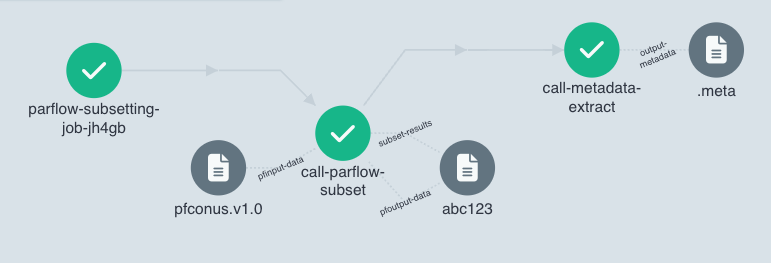